Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StanModels

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path_s("..", "scripts", "13")
cd(ProjDir)

### snippet 13.1

In [3]:
wd = CSV.read(rel_path("..", "data", "UCBadmit.csv"), delim=';');
df = convert(DataFrame, wd);

Preprocess data

In [4]:
df[:admit] = convert(Vector{Int}, df[:admit])
df[:applications] = convert(Vector{Int}, df[:applications])
df[:male] = [(df[:gender][i] == "male" ? 1 : 0) for i in 1:size(df, 1)];
df[:dept_id] = [Int(df[:dept][i][1])-64 for i in 1:size(df, 1)];
first(df, 5)

m13_2 = "
  data{
      int N;
      int N_depts;
      int applications[N];
      int admit[N];
      real male[N];
      int dept_id[N];
  }
  parameters{
      vector[N_depts] a_dept;
      real a;
      real bm;
      real<lower=0> sigma_dept;
  }
  model{
      vector[N] p;
      sigma_dept ~ cauchy( 0 , 2 );
      bm ~ normal( 0 , 1 );
      a ~ normal( 0 , 10 );
      a_dept ~ normal( a , sigma_dept );
      for ( i in 1:N ) {
          p[i] = a_dept[dept_id[i]] + bm * male[i];
          p[i] = inv_logit(p[i]);
      }
      admit ~ binomial( applications , p );
  }
";

Define the Stanmodel and set the output format to :mcmcchain.

In [5]:
stanmodel = Stanmodel(name="m13_2", model=m13_2,
monitors=["a", "bm", "sigma_dept", "a_dept.1", "a_dept.2", "a_dept.3",
"a_dept.4", "a_dept.5", "a_dept.6"],
output_format=:mcmcchain);


File /Users/rob/.julia/dev/StanModels/scripts/13/tmp/m13_2.stan will be updated.



Input data for cmdstan

In [6]:
ucdata = Dict("N" => size(df, 1), "N_depts" => maximum(df[:dept_id]), "admit" => df[:admit],
"applications" => df[:applications],  "dept_id"=> df[:dept_id], "male" => df[:male]);

Sample using cmdstan

In [7]:
rc, chn, cnames = stan(stanmodel, ucdata, ProjDir, diagnostics=false,
  summary=false, CmdStanDir=CMDSTAN_HOME);
# Describe the draws
describe(chn)

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
               Mean         SD       Naive SE       MCSE      ESS
  a_dept.1  0.66869063 0.100195009 0.0015842222 0.0022805315 1000
  a_dept.2  0.62249124 0.113089239 0.0017880979 0.0026076103 1000
  a_dept.3 -0.58575674 0.075508521 0.0011938946 0.0014849673 1000
  a_dept.4 -0.61754379 0.086104754 0.0013614357 0.0017330124 1000
  a_dept.5 -1.05895990 0.100058413 0.0015820624 0.0016968655 1000
  a_dept.6 -2.61306747 0.154196446 0.0024380599 0.0023317698 1000
         a -0.60568653 0.638700803 0.0100987464 0.0134796179 1000
        bm -0.09021798 0.080547386 0.0012735660 0.0020891698 1000
sigma_dept  1.48244759 0.602120346 0.0095203586 0.0110002046 1000

Quantiles:
               2.5%       25.0%       50.0%        75.0%       97.5%   
  a_dept.1  0.47592690  0.59900625  0.66692250  0.737929750  0.86262988
  a_dept.2  0.40339548  0.54786525  0.62044300  0.697940750  0.84516

Plot the density of posterior draws

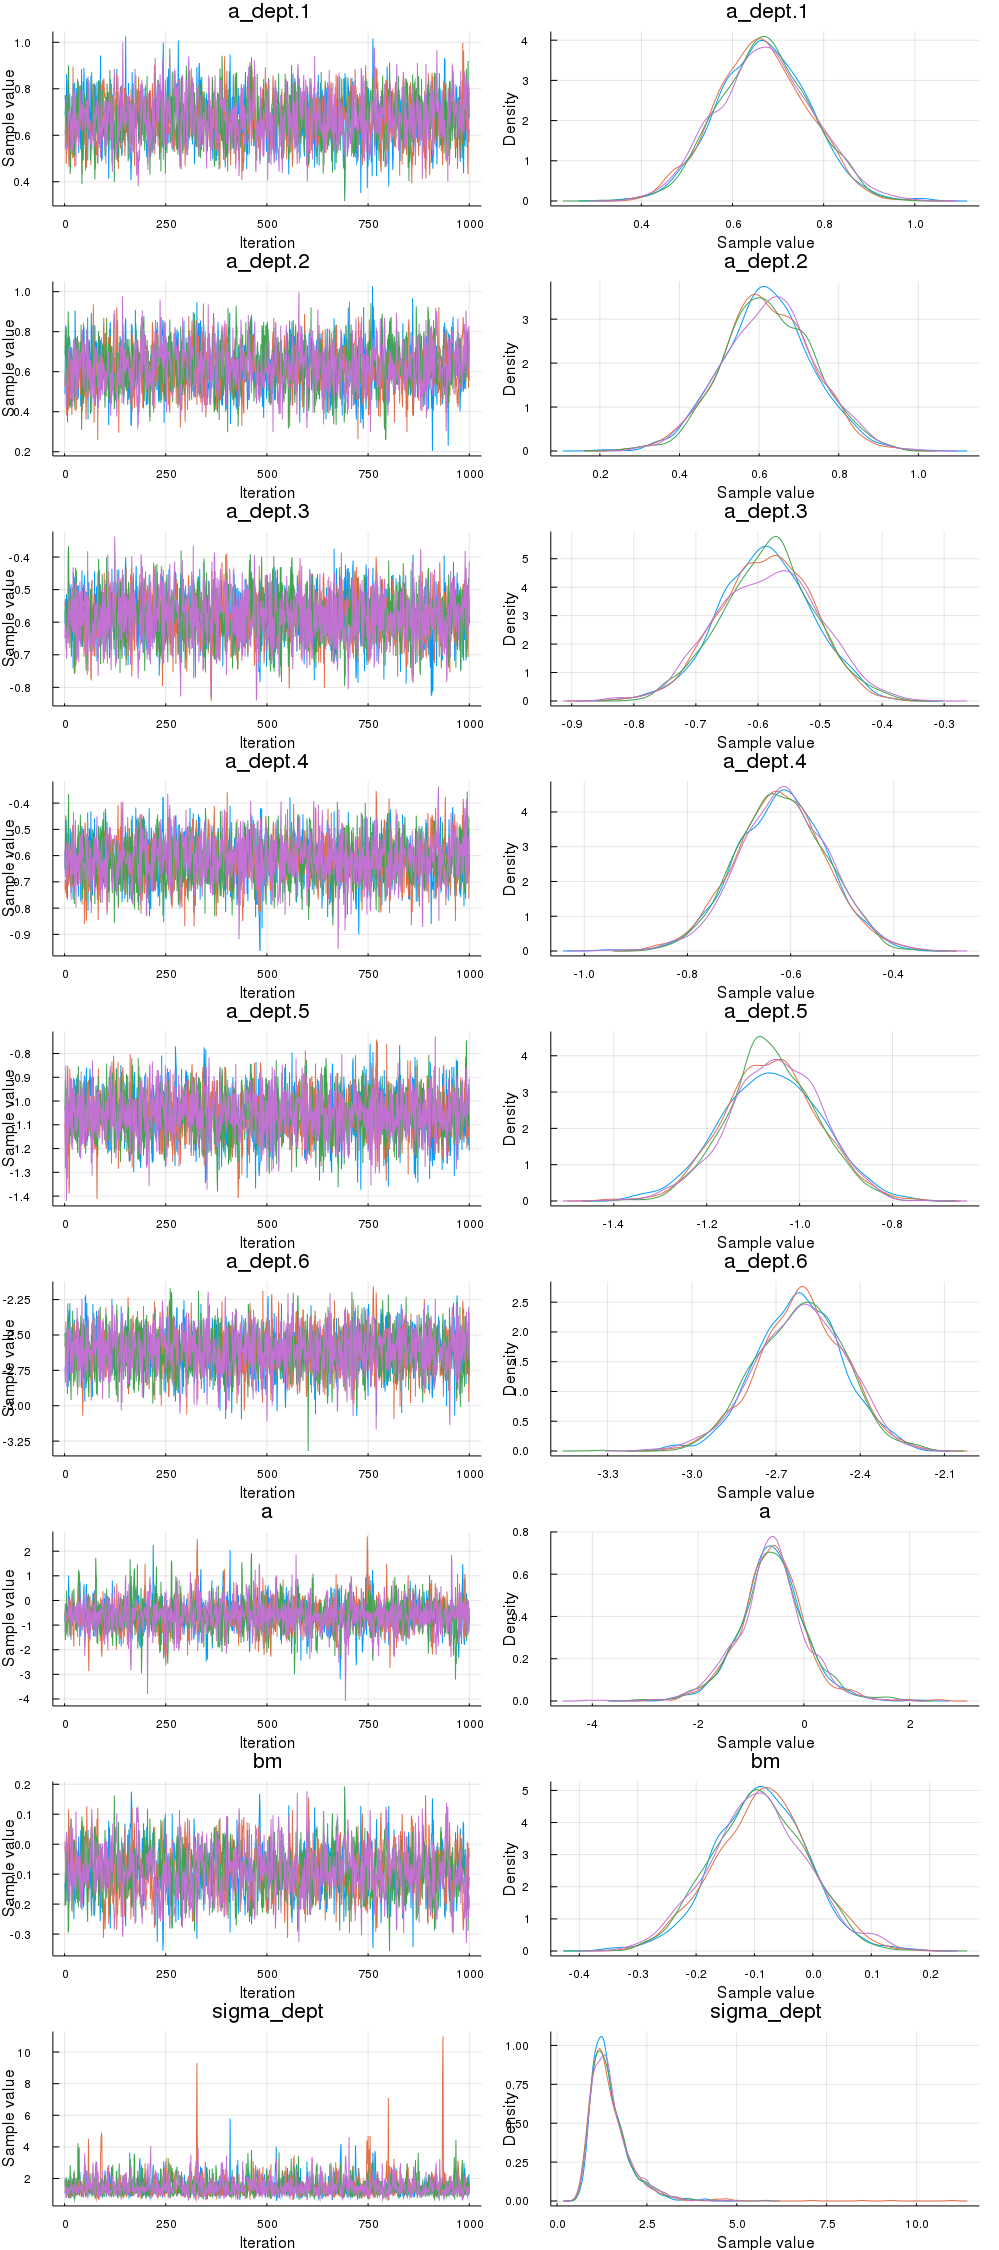

In [8]:
plot(chn)

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*